In [24]:
#Second part of figure 4. the weight changes over training

import torch, sys, os, io, pickle, json, glob, copy
from os.path import exists
import numpy as np
from scipy.special import softmax
from scipy import stats
from scipy.stats import ranksums, wilcoxon

import matplotlib.pyplot as plt
import matplotlib


from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot
from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.analysis import state_analysis as sta

%load_ext autoreload
%autoreload 2

dbase = '/Users/dhocker/projects/dynamics/results/20231003/'

num_rnns = {0:50, 1:50, 2:20, 3:10, 4:10, 5:10, 6:10, 7:10, 8:10}  # number of RNNs per training type, by sidx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
#the weights across training for single rnn

def weight_outpt_acrosstraining(s_idx = 0, num = 0, n_kind = 1, n_inf = 1,
                                device=torch.device('cpu'), modeltype = 'RNNModel_multiregion_2allt'):
    """
    gets the output projection across an entire set of training. does not include kindergarten 
    s_idx: CL type 0:full, 1:nok_cl, 2: nok_nocl
    num: RNN number
    n_kind: frequency of sampling hard kindergareten checkpoints
    n_inf: frequency of sampling inference checkpoints
    device: torch device spec
    modeltype: (str) of model type used from process/nets.py. 
    """

    stagelist = []  # list of tphase for each model found
    idxlist = []  # list of idx within tphase for each model found
    
    #lin sensitivity, wt ratio, historical regression, opt out, violation

    w_pred = []  # output weights to inference-task-relevant head (1 x N)
    w_policy = [] # output weights to policy-relevant head (3 x N)
    w_val = []  # output weights to value-relevant head (1 x N)
    w_rr =[] # output weights to stimulus-integration-task-relevant head
    w_mem = [] # output weights to memory-task-relevant head
    w_time = [] # output weights to counting-task-relevant head
    w_str_rnn = [] # recurrent weights in str (N x 4N) 4 gates in LSTM, so stached here
    w_ofc_rnn = [] # reucrrent weights in ofc (N x 4N) 4 gates in LSTM, so stacked here
    w_str_inp = [] # input weights to str
    w_ofc_inp = [] # input weight to ofc
    
    
    #base directory where all relevant model files would be found
    d = utils.getfnames(num, s_idx, 5, 10, dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')
    datadir_dat = d['init'].split('rnn_init')[0]
    
    
    #find max int and pred in the directory
    nmax_simple = len(glob.glob(datadir_dat+'/rnn_kindergarten_'+str(num)+'_simple.model'))
    nmax_kind = len(glob.glob(datadir_dat+'/rnn_kindergarten_'+str(num)+'_int*.model'))
    #set a maximum of 100 for this to avoid a runaway simulation 
    nmax_inf = np.min([100,len(glob.glob(datadir_dat+'/rnn_pred_'+str(num)+'*.model'))])
    
    #idx of networks to pull for each portion of training
    idxranges = [range(1,nmax_simple+1), range(1,nmax_kind+1, n_kind), range(1,nmax_inf+1, n_inf), 
                 range(1,11), range(1,11), range(1,61)]
       
    #create dummy network
    nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
    netfun = nd['net']  
    netseed = num
    net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
                 bias_init=0)
    
    stagelist.append(-1)
    idxlist.append(0)
    
    # initial conditions. same as in training because of netseed
    w_ofc = net.linear1.weight.detach().numpy()
    w_str = net.linear2.weight.detach().numpy()
    w_pred.append(w_ofc[0:3,:]) #predition
    w_policy.append(w_str[0:3,:]) #policies
    w_val.append(w_str[3,:])
    w_mem.append(w_str[4,:])
    w_time.append(w_str[5,:])
    w_rr.append(w_ofc[3,:])
    w_ofc_rnn.append(net.rnn1.weight_hh_l0.detach().numpy())
    w_str_rnn.append(net.rnn2.weight_hh_l0.detach().numpy())
    w_ofc_inp.append(net.rnn1.weight_ih_l0.detach().numpy())
    w_str_inp.append(net.rnn2.weight_ih_l0.detach().numpy())
    
    wnan = np.nan*net.rnn1.weight_hh_l0.detach().numpy()
    wnan_ofc_inp = np.nan*net.rnn1.weight_ih_l0.detach().numpy()
    wnan_str_inp = np.nan*net.rnn2.weight_ih_l0.detach().numpy()
    
    
    for stage in range(6):
    
        for idx in idxranges[stage]:  
            
            d = utils.getfnames(num, s_idx, stage, idx, dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')
            
            fname_model = d['model']

            if exists(fname_model):           
                try:       
                    stagelist.append(stage)
                    idxlist.append(idx)

                    #load the model
                    nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
                    netfun = nd['net']  
                    netseed = num
                    net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
                                 bias_init=0)

                    net.load_state_dict(torch.load(fname_model, map_location=device.type))

                    #extract weights
                    w_ofc = net.linear1.weight.detach().numpy()
                    w_str = net.linear2.weight.detach().numpy()
                    w_pred.append(w_ofc[0:3,:])
                    w_policy.append(w_str[0:3,:])
                    w_val.append(w_str[3,:])
                    w_mem.append(w_str[4,:])
                    w_time.append(w_str[5,:])
                    w_rr.append(w_ofc[3,:])
                    w_ofc_rnn.append(net.rnn1.weight_hh_l0.detach().numpy())
                    w_str_rnn.append(net.rnn2.weight_hh_l0.detach().numpy())
                    w_ofc_inp.append(net.rnn1.weight_ih_l0.detach().numpy())
                    w_str_inp.append(net.rnn2.weight_ih_l0.detach().numpy())
                except:
                    print('issue: something might be up with .model file: '+fname_model)
                    w_ofc_rnn.append(wnan)
                    w_str_rnn.append(wnan)
                    w_ofc_inp.append(wnan_ofc_inp)
                    w_str_inp.append(wnan_str_inp)
                
                    
    d = {'w_pred':w_pred ,
    'w_mem':w_mem ,
    'w_time':w_time,
    'w_policy':w_policy ,
    'w_val':w_val ,
    'w_rr':w_rr,
    'w_ofc_rnn':w_ofc_rnn,
    'w_str_rnn':w_str_rnn,
    'w_ofc_inp':w_ofc_inp,
    'w_str_inp':w_str_inp}

                
    return d, stagelist, idxlist
                


In [36]:
#confirm that initailization of networks is the same as some saved ones

device = torch.device('cpu')
modeltype = 'RNNModel_multiregion_2allt'

num = 3
s_idx = 0

#initialize a network 
nd = wt_nets.netdict[modeltype]  # dictionary of models and size params
netfun = nd['net']  
netseed = num
net = netfun(din=nd['din'], dout=nd['dout'], num_hiddens=[256,256], seed=netseed, rnntype='LSTM',
             bias_init=0)
w_ofc = net.linear1.weight.detach().numpy()



# compare to one saved during run
d = utils.getfnames(num, s_idx, 3, 10, dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')
fname_init = d['init']
net.load_state_dict(torch.load(fname_init, map_location=device.type))                
w_ofc_true = net.linear1.weight.detach().numpy()

print(w_ofc[0,0:20])
print(w_ofc_true[0,0:20])

[ 0.01938847  0.02319529 -0.03588345 -0.04444642 -0.05373296  0.00488897
  0.0184447  -0.01232195  0.05217092 -0.01136886 -0.02585177 -0.02835011
  0.04504063 -0.05842583 -0.04468738 -0.0093355  -0.01996568 -0.04710723
  0.05197722  0.03803706]
[ 0.01938847  0.02319529 -0.03588345 -0.04444642 -0.05373296  0.00488897
  0.0184447  -0.01232195  0.05217092 -0.01136886 -0.02585177 -0.02835011
  0.04504063 -0.05842583 -0.04468738 -0.0093355  -0.01996568 -0.04710723
  0.05197722  0.03803706]


In [4]:
#determine frequency of models for inference and hard kindergarten
lr_task = 0.0001
lr_kind = 0.0001
lr_pred = 0.005
base_epoch_kind = 1000 # frequency of saves, in num of gradient updates (in this case, epochs)
base_epcoh_pred = 20  # frequency of savings, in num of gradient updates (in this case, epochs)
base_epoch_task = 1000  # frequency of saves, in num of gradient updates (approximately. 10k saves ~ 1k updates)

r_task = base_epoch_task*lr_task
r_kind = base_epoch_kind*lr_kind
r_pred = base_epcoh_pred*lr_pred

#frequency
n_kind = int(r_task/r_kind)
n_inf = int(r_task/r_pred)

print([n_kind, n_inf])

[1, 1]


In [40]:
nnum = 18
d, stagelist, idxlist = weight_outpt_acrosstraining(num = nnum, s_idx = 0, n_kind = n_kind, n_inf = n_inf)
d.keys()

dict_keys(['w_pred', 'w_mem', 'w_time', 'w_policy', 'w_val', 'w_rr', 'w_ofc_rnn', 'w_str_rnn', 'w_ofc_inp', 'w_str_inp'])

In [41]:
def acrossdat_weightchange(s_idx):
    """ aggregates weight changes over learning for entire population, given a CL type
        s_idx: CL type
    """
    print(s_idx)

    lenlist = []
    predlist_ofc = []
    predlist_str = []
    stagelist_list= []
    
    nm = [1, 9, 100, 10, 10, 60]  # max samples for each stage. 
    nn = num_rnns[s_idx]  # number of RNNs, for given CL type
    
    predmats_ofc = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_str = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_ofc_inp = [np.nan*np.ones((nn,k)) for k in nm]
    predmats_str_inp = [np.nan*np.ones((nn,k)) for k in nm]

    for j in range(1,nn+1):
        print(j,end='\r')
        nnum = j
        d, stagelist, idxlist = weight_outpt_acrosstraining(num = nnum, s_idx = s_idx, n_kind=n_kind, n_inf=n_inf)
          
        for k in range(6):
            #indices to use for this 
            idx_use = list(np.argwhere(np.array(stagelist)==k)[:,0])
            nidx = len(idx_use)
            
            test = np.array([np.linalg.norm(d['w_ofc_rnn'][m]-d['w_ofc_rnn'][m-1]) for m in idx_use]) 
            predmats_ofc[k][j-1,:len(test)] = test
            test = np.array([np.linalg.norm(d['w_str_rnn'][m]-d['w_str_rnn'][m-1]) for m in idx_use]) 
            predmats_str[k][j-1,:len(test)] = test
            
            test = np.array([np.linalg.norm(d['w_ofc_inp'][m]-d['w_ofc_inp'][m-1]) for m in idx_use]) 
            predmats_ofc_inp[k][j-1,:len(test)] = test
            test = np.array([np.linalg.norm(d['w_str_inp'][m]-d['w_str_inp'][m-1]) for m in idx_use]) 
            predmats_str_inp[k][j-1,:len(test)] = test
            
        predlist_ofc = np.concatenate(tuple(k for k in predmats_ofc),axis=1)
        predlist_str = np.concatenate(tuple(k for k in predmats_str),axis=1)
        predlist_ofc_inp = np.concatenate(tuple(k for k in predmats_ofc_inp),axis=1)
        predlist_str_inp = np.concatenate(tuple(k for k in predmats_str_inp),axis=1)

        
    return predlist_ofc, predlist_str, predlist_ofc_inp, predlist_str_inp



predlist_ofc_padded, predlist_str_padded, predlist_ofc_inp_padded, predlist_str_inp_padded = acrossdat_weightchange(s_idx = 0)
predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl, predlist_str_inp_padded_nok_cl = acrossdat_weightchange(s_idx = 1)
predlist_ofc_padded_nok_nocl, predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl = acrossdat_weightchange(s_idx = 2)


0
10
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/21/rnn_curric_21_block_24.model
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/26/rnn_curric_26_block_24.model
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/27/rnn_curric_27_block_23.model
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/28/rnn_curric_28_block_26.model
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/29/rnn_curric_29_block_5.model
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/29/rnn_curric_29_block_22.model
issue: something might be up with .model file: /Users/dhocker/projects/dynamics/results/20231003/nok_cl/30/rnn_curric_30_block_8.model
issue: something might be up with .model file

In [42]:
# time warp the inference portion of training, since they have variable training times

predlens = [len(glob.glob(dbase+'full_cl/'+str(num)+'/rnn_pred_'+str(num)+'*.model')) for num in range(1,51)]

med_pred = np.floor(np.median(predlens)).astype(int)  # median length of each phase. warp to this length
ps_idx = 10
pe_idx_old = ps_idx + 100

predmesh_new = np.linspace(0,1,med_pred)

predlist = [predlist_ofc_padded,predlist_str_padded,predlist_ofc_inp_padded,predlist_str_inp_padded, 
            predlist_ofc_padded_nok_cl, predlist_str_padded_nok_cl, predlist_ofc_inp_padded_nok_cl,predlist_str_inp_padded_nok_cl,
            predlist_ofc_padded_nok_nocl,predlist_str_inp_padded_nok_nocl, predlist_ofc_inp_padded_nok_nocl, predlist_str_padded_nok_nocl]

predlist_new = []

i = 0

for m in predlist:
    preddat_m = copy.deepcopy(m)
    
    pred_m = []

    for k in range(len(preddat_m)):
        test = list(preddat_m[k])

        clip_idx_base = np.argwhere(np.isnan(test))
        clip_idx = clip_idx_base[0,0]
        j = 0
        while clip_idx <= ps_idx: # find first instance where it is greater than 
            clip_idx = clip_idx_base[j,0]
            j+=1

        #extract old pred section
        pred_old = test[ps_idx:clip_idx]
        predmesh_old = np.linspace(0,1,clip_idx-ps_idx)
        #interpolate
        pred_new = np.interp(predmesh_new,predmesh_old,pred_old)
        # cut oold data
        [test.pop(ps_idx) for j in range(100)]  #keep popping old data as it hits that index
        # insert new data
        [test.insert(ps_idx+k, pred_new[k]) for k in range(len(pred_new))]


        pred_m.append(np.array(test))
    predlist_new.append(pred_m)
    i +=1


In [43]:
dowarp = True
if dowarp:
    predlist_ofc_padded = np.array(predlist_new[0])
    predlist_str_padded = np.array(predlist_new[1]) 
    predlist_ofc_inp_padded = np.array(predlist_new[2])
    predlist_str_inp_padded = np.array(predlist_new[3])
    predlist_ofc_padded_nok_cl = np.array(predlist_new[4])
    predlist_str_padded_nok_cl = np.array(predlist_new[5])
    predlist_ofc_inp_padded_nok_cl = np.array(predlist_new[6])
    predlist_str_inp_padded_nok_cl = np.array(predlist_new[7])
    predlist_ofc_padded_nok_nocl = np.array(predlist_new[8])
    predlist_str_inp_padded_nok_nocl = np.array(predlist_new[9])
    predlist_ofc_inp_padded_nok_nocl = np.array(predlist_new[10])
    predlist_str_padded_nok_nocl = np.array(predlist_new[11])

/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/1901672514.py:20: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_str_padded, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/1901672514.py:23: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_str_padded_nok_cl, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/1901672514.py:26: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_str_padded_nok_nocl, axis=0)


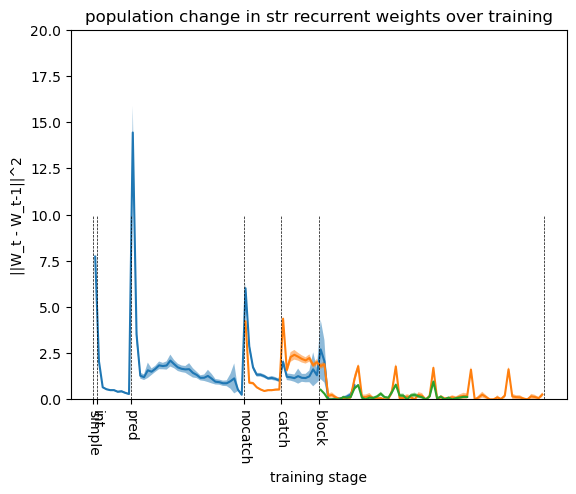

In [44]:
# Figure 4E. change in STR recurrent weights over traiing

lmax = predlist_str_padded.shape[1]
lmax_nok_nocl = predlist_str_padded_nok_nocl.shape[1]
lmax_nok_cl = predlist_str_padded_nok_cl.shape[1]

#max samples for each stage. note how max number of samples from pred is 100? that matches the above constraint
if dowarp:
    nm = [0,1, 9, med_pred, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]
else:
    nm = [0,1, 9, 100, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]


clstart = sum(nm[0:2])
noclstart = sum(nm[0:3])


diffmean = np.nanmean(predlist_str_padded, axis=0)
diffsem = np.nanstd(predlist_str_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_str_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_str_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_str_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_str_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)

plt.title('population change in str recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,20])


plt.show()

/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/4144516066.py:3: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_ofc_padded, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/4144516066.py:6: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_ofc_padded_nok_cl, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/4144516066.py:9: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_ofc_padded_nok_nocl, axis=0)


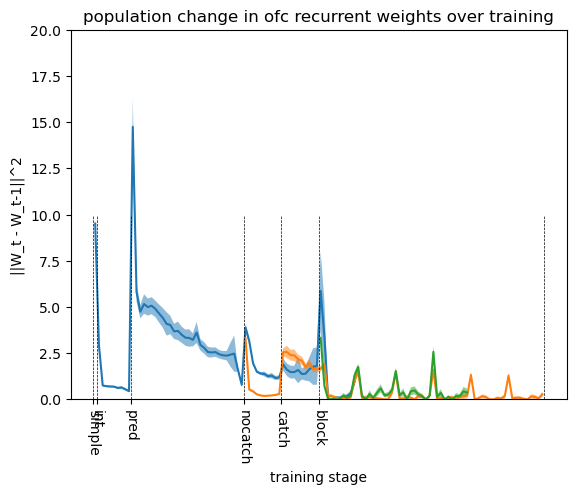

In [45]:
# Figure 4E. change in OFC recurrent weights over traiing

diffmean = np.nanmean(predlist_ofc_padded, axis=0)
diffsem = np.nanstd(predlist_ofc_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_ofc_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_ofc_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_ofc_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_ofc_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
plt.title('population change in ofc recurrent weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,20])

    
plt.show()

(120,)


/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/3322287954.py:21: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_str_inp_padded, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/3322287954.py:25: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_str_inp_padded_nok_cl, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/3322287954.py:28: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_str_inp_padded_nok_nocl, axis=0)


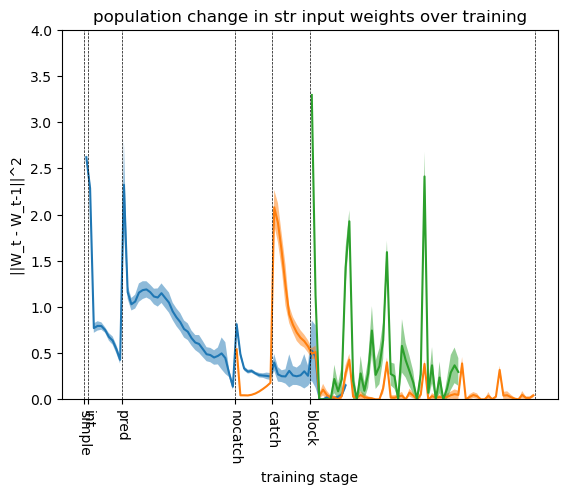

In [46]:
# supp Fig. STR input weights

lmax = predlist_str_inp_padded.shape[1]
lmax_nok_nocl = predlist_str_inp_padded_nok_nocl.shape[1]
lmax_nok_cl = predlist_str_inp_padded_nok_cl.shape[1]

#max samples for each stage. note how max number of samples from pred is 100? that matches the above constraint
if dowarp:
    nm = [0,1, 9, med_pred, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]
else:
    nm = [0,1, 9, 100, 10, 10, 60]
    nm0 = [0, 1, 9, 10, 10, 10]


#lmax = sum(nm)
clstart = sum(nm[0:2])
noclstart = sum(nm[0:3])


diffmean = np.nanmean(predlist_str_inp_padded, axis=0)
print(diffmean.shape)
diffsem = np.nanstd(predlist_str_inp_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_str_inp_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_str_inp_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_str_inp_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_str_inp_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

#find a completed network and grab its stagelist
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
plt.title('population change in str input weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')
plt.ylim([0,4])


plt.show()

/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/2360937524.py:3: RuntimeWarning: Mean of empty slice
  diffmean = np.nanmean(predlist_ofc_inp_padded, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/2360937524.py:6: RuntimeWarning: Mean of empty slice
  diffmean_nok_cl = np.nanmean(predlist_ofc_inp_padded_nok_cl, axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_22438/2360937524.py:9: RuntimeWarning: Mean of empty slice
  diffmean_nok_nocl = np.nanmean(predlist_ofc_inp_padded_nok_nocl, axis=0)


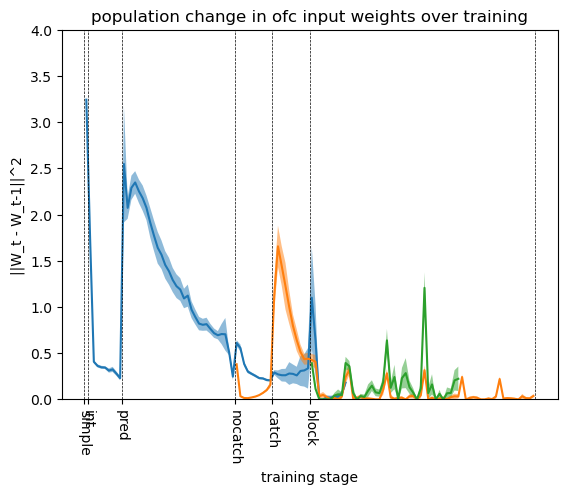

In [47]:
# supp Fig. OFC input weights

diffmean = np.nanmean(predlist_ofc_inp_padded, axis=0)
diffsem = np.nanstd(predlist_ofc_inp_padded, axis=0)/np.sqrt(20)

diffmean_nok_cl = np.nanmean(predlist_ofc_inp_padded_nok_cl, axis=0)
diffsem_nok_cl = np.nanstd(predlist_ofc_inp_padded_nok_cl, axis=0)/np.sqrt(20)

diffmean_nok_nocl = np.nanmean(predlist_ofc_inp_padded_nok_nocl, axis=0)
diffsem_nok_nocl = np.nanstd(predlist_ofc_inp_padded_nok_nocl, axis=0)/np.sqrt(20)

plt.plot(range(lmax),diffmean)
plt.fill_between(range(lmax),diffmean-diffsem, diffmean+diffsem, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_cl)
plt.fill_between(range(lmax),diffmean_nok_cl-diffsem_nok_cl, diffmean_nok_cl+diffsem_nok_cl, alpha = 0.5)

plt.plot(range(lmax),diffmean_nok_nocl)
plt.fill_between(range(lmax),diffmean_nok_nocl-diffsem_nok_nocl, diffmean_nok_nocl+diffsem_nok_nocl, alpha = 0.5)

stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block'}
[plt.vlines(k-0.5,  0, 10, color='k',linewidth = 0.5, linestyle = 'dashed') for k in np.cumsum(nm)]
plt.xticks(np.cumsum(nm[:-1])-0.5, labels = [stagedict[k] for k in range(len(nm)-1)], rotation = -90)
plt.title('population change in ofc input weights over training')
plt.xlabel('training stage')
plt.ylabel('||W_t - W_t-1||^2')

plt.ylim([0,4])

    
plt.show()